In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [24]:
movie_ratings = pd.read_csv("C:/Users/Saurav_kumar/Desktop/movie_ratings.csv")

In [25]:
df=movie_ratings.copy()
df.head(10)

,user,movie,rating,id
0,2783,1253,5,2783_1253
1,2783,589,5,2783_589
2,2783,1270,4,2783_1270
3,2783,1274,4,2783_1274
4,2783,741,5,2783_741
5,2783,750,5,2783_750
6,2783,924,5,2783_924
7,2783,2407,4,2783_2407
8,2783,3070,3,2783_3070
9,2783,208,1,2783_208


In [4]:
df.isnull().sum()

user      0
movie     0
rating    0
id        0
dtype: int64

In [5]:
df.describe()

,user,movie,rating
count,500100.000000,500100.000000,500100.000000
mean,4408.620518,1834.281214,3.602224
std,926.274862,1076.388887,1.114688
min,2783.000000,1.000000,1.000000
25%,3622.000000,1022.000000,3.000000
50%,4371.000000,1767.000000,4.000000
75%,5220.000000,2724.000000,4.000000
max,6040.000000,3952.000000,5.000000


In [6]:
users = df['user'].unique()
len(users)

3255

In [7]:
movies = df['movie'].unique()
len(movies)

3551

In [20]:
moviemat=df.pivot_table(index='user', columns='movie', values='rating')

In [21]:
moviemat = moviemat.fillna(0).as_matrix()
moviemat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [22]:
moviemat.shape

(3255, 3551)

In [23]:
moviemat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [15]:
sparsity = float(len(moviemat.nonzero()[0]))
sparsity /= (len(users) * len(movies))
sparsity *= 100
sparsity

4.326684117020324

In [34]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(pred, true_values):
    pred = pred[true_values.nonzero()].flatten()
    true_values = true_values[true_values.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, true_values))

In [35]:
def train_test_split(ratings):
    
    validation = np.zeros(ratings.shape)
    train = ratings.copy() #don't do train=ratings, other wise, ratings becomes empty
    
    for user in np.arange(ratings.shape[0]):
        if len(ratings[user,:].nonzero()[0])>=35:# 35 seems to be best, it depends on sparsity of your user-item matrix
            val_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=15, #tweak this, 15 seems to be optimal
                                        replace=False)
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]
    print(validation.shape)
    return train, validation

In [36]:
train, val = train_test_split(moviemat)

(3255, 3551)


In [37]:
train.shape, val.shape

((3255, 3551), (3255, 3551))

In [42]:
def prediction(P, Q):
    return np.dot(P.T, Q)

In [60]:
lmbda = 0.3
k = 10
m ,n = train.shape
epochs = 20
alpha = 0.01
P = 3 * np.random.rand(k,m)
Q = 3* np.random.rand(k,n)

In [61]:
train_errors = []
val_errors = []

users, items = train.nonzero()
for epoch in range(epochs):
    for u, i in zip(users, items):
        e = train[u, i] - prediction(P[:,u],Q[:,i])
        P[:,u] += alpha * (e * Q[:,i] - lmbda * P[:,u])
        Q[:,i] += alpha * (e * P[:,u] - lmbda * Q[:,i])
    
    train_rmse = rmse(prediction(P,Q), train)
    val_rmse = rmse(prediction(P,Q), val)
    train_errors.append(train_rmse)
    val_errors.append(val_rmse)
    print(epoch,' : ' , val_rmse)

0  :  2.5692859050322747
1  :  1.5164585681466
2  :  1.2026322999942625
3  :  1.1037529073724701
4  :  1.0661594334320148
5  :  1.047781565688679
6  :  1.0370323212772306
7  :  1.0299956299127018
8  :  1.0250403654470792
9  :  1.0213694228651906
10  :  1.0185463746731285
11  :  1.016311979342156
12  :  1.0145025771425047
13  :  1.0130098171564001
14  :  1.011759153234229
15  :  1.0106976361694482
16  :  1.00978663239415
17  :  1.0089972990555605
18  :  1.0083076721100055
19  :  1.007700734992912


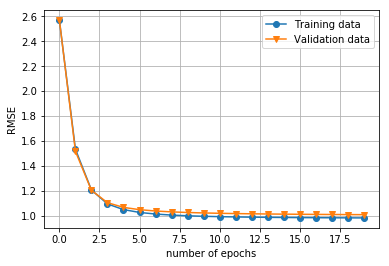

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(epochs), train_errors, marker = 'o', label = 'Training data')
plt.plot(range(epochs), val_errors, marker='v', label = 'Validation data')
plt.xlabel('number of epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()


In [66]:
SGD_prediction = prediction(P,Q)

estimation = SGD_prediction[val.nonzero()]
true_values = val[val.nonzero()]
result = pd.DataFrame({'prediction' : estimation, 'rated' : true_values})

result

,prediction,rated
0,3.766693,3.0
1,2.457971,1.0
2,3.239115,3.0
3,3.752295,4.0
4,4.035154,5.0
5,4.246543,5.0
6,3.800507,5.0
7,3.818262,3.0
8,3.502400,4.0
9,3.519758,5.0
